In [175]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
file_path =  "drive/MyDrive/REDS_DATA/utils.py"
exec(open(file_path).read())

In [177]:
from transformers import ViTForImageClassification,ViTConfig, ViTImageProcessor
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
from tqdm import tqdm
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt

In [178]:
import os
import cv2
import numpy as np
from pathlib import Path
from skimage.transform import resize

TRAIN_PATH_DATASET = "drive/MyDrive/REDS_DATA/data/train/"
TEST_PATH_DATASET = "drive/MyDrive/REDS_DATA/data/test/"

HIPPO_DIR = "hippo/"
RHINO_DIR = "rhino/"

IMG_SHAPE = (224, 224)

def load_dataset(test=False, transform=False):
    path_dataset = TEST_PATH_DATASET if test else TRAIN_PATH_DATASET

    hippo_path = os.path.join(path_dataset, HIPPO_DIR)
    rhino_path = os.path.join(path_dataset, RHINO_DIR)

    hippo_images = []
    rhino_images = []

    # Load Hippo images
    for filename in os.listdir(hippo_path):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(hippo_path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            if transform:
                img = resize(img, IMG_SHAPE, anti_aliasing=True)

            hippo_images.append(img)

    # Load Rhino images
    for filename in os.listdir(rhino_path):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(rhino_path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            if transform:
                img = resize(img, IMG_SHAPE, anti_aliasing=True)

            rhino_images.append(img)

    # Create corresponding labels (0 for hippo, 1 for rhino)
    hippo_labels = np.zeros(len(hippo_images))
    rhino_labels = np.ones(len(rhino_images))

    # Combine images and labels
    images = np.concatenate([hippo_images, rhino_images], axis=0)
    labels = np.concatenate([hippo_labels, rhino_labels], axis=0)

    return images, labels


# Fonction pour sauvegarder les images à partir de array
def save_images(images, labels, test=False):
    path_dataset = TEST_PATH_DATASET if test else TRAIN_PATH_DATASET

    n_hippo = 1
    n_rhino = 1

    # Convertir et sauvegarder chaque image
    for i, image in enumerate(images):
        img_dir = HIPPO_DIR if labels[i] == 0 else RHINO_DIR
        n_img = n_hippo if labels[i] == 0 else n_rhino

        save_path = os.path.join(path_dataset, img_dir)

        # Créer le chemin complet pour sauvegarder l'image
        image_name = f"{n_img}.jpg"
        image_path = os.path.join(save_path, image_name)

        if labels[i] == 0:
            n_hippo += 1
        else:
            n_rhino += 1

        image = image.reshape(*IMG_SHAPE, 1)

        image = (image * 255).astype(np.uint8)
        cv2.imwrite(image_path, image)

In [179]:
save_path = Path("model.pch")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')



#Frizer le model
for parameter in  model.parameters() :
  parameter.requires_grad = False

#changer la derniere couche
nb_classe = 2
model.classifier = nn.Linear(model.config.hidden_size, nb_classe)

In [180]:
train_images,label_train = load_dataset()
test_images,test_label = load_dataset(test =True)

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

tensor_tr = torch.stack([transform_data(image) for image in train_images])
tensor_ts = torch.stack([transform_data(image) for image in test_images])


tensor_test = tensor_ts.expand(-1, 3, -1, -1).to(torch.float32)
tensor_train = tensor_tr.expand(-1, 3, -1, -1).to(torch.float32)

train_tensor = TensorDataset(tensor_train,torch.tensor(label_train, dtype = torch.long))
test_tensor = TensorDataset(tensor_test,torch.tensor(test_label, dtype = torch.long))

BATCH_SIZE = 32


Train = DataLoader(train_tensor,shuffle=True, batch_size = BATCH_SIZE)
Test = DataLoader(test_tensor,shuffle = False)

In [181]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

In [182]:
num_epochs = 10
model = model.to(device)
accuracy_train = []
loss_train = []

accuracy_test = []
loss_test = []


for epoch in range(num_epochs):
  acc_accuracy_train = 0
  acc_accuracy_test = 0
  acc_loss_train = 0
  acc_loss_test = 0
  data_train_tqdm = tqdm(Train,desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False, dynamic_ncols=True)
  data_test_tqdm = tqdm(Test,desc=f'Epoch {epoch + 1}/{num_epochs}',leave = False,dynamic_ncols=True)
  for data,label in data_train_tqdm:
      # Forward pass
      data = data.to(device)
      label = label.to(device)
      outputs = model(data)
      prediction = outputs.logits
      predict_final = torch.argmax(prediction, axis = 1)
      acc_accuracy_train += accuracy(predict_final,label, task = "BINARY")
      loss_ = loss(prediction, label)
      acc_loss_train += loss_.item()
      optimizer.zero_grad()
      loss_.backward()
      optimizer.step()
      if epoch %  3 == 0 :
        with save_path.open('wb') as fp :
          torch.save(model,fp)
  acc = (acc_accuracy_train / len(Train))
  accuracy_train.append(acc)
  loss_train.append(acc_loss_train)


  with torch.no_grad() :
    for data_test,label_test in Test :
      data_test = data_test.to(device)
      label_test = label_test.to(device)
      output = model(data_test)
      prediction = output.logits
      acc_loss_test += loss(prediction,label_test).item()
      acc_accuracy_test += accuracy(torch.argmax(prediction,axis = 1),label_test,task = "BINARY")
  accuracy_test.append(acc_accuracy_test/len(Test))
  loss_test.append(acc_loss_test)




Epoch 1/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/200 [00:00<?, ?it/s]


In [183]:
list_acc_train = [acc.item() for acc in accuracy_train]
list_acc_test = [acc.item() for acc in accuracy_test]

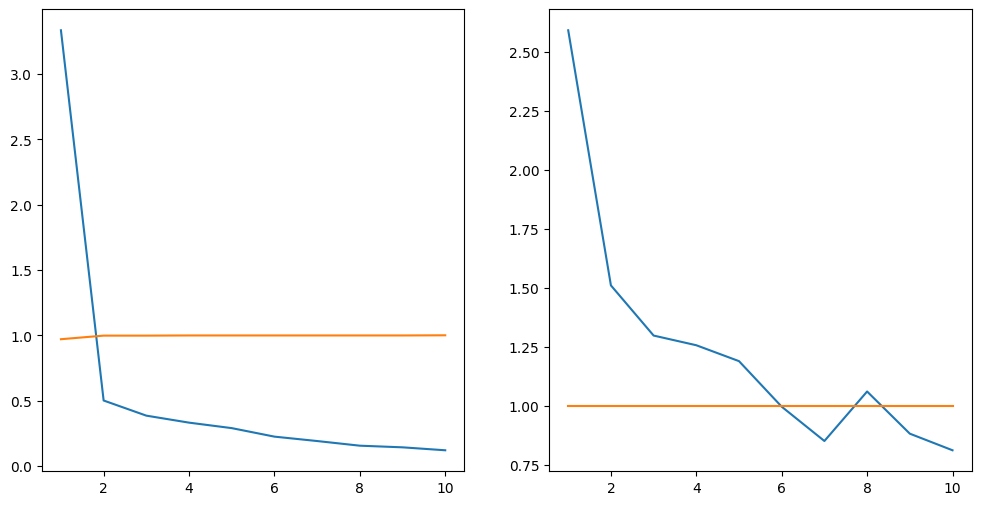

In [184]:
plt.figure(figsize=(12, 6))
epochs = range(1,num_epochs+1)

plt.subplot(1,2,1)
plt.plot(epochs,loss_train, label = "train loss")
plt.plot(epochs,list_acc_train,label = "accuracy train")
plt.subplot(1,2,2)
plt.plot(epochs,loss_test, label = "test loss")
plt.plot(epochs,list_acc_test,label = "accuracy test")
